# Aligater QC

In [77]:
#Bokeh & standard imports
import numpy as np
import pandas as pd

from bokeh.plotting import gridplot, figure, show, save
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.events import SelectionGeometry, Event
import subprocess
import aligater as ag

**Create AliGater QC object and load the HDF5 format file** produced by AliGator during the gating. This file contains downsampled images (128x128 resolution) of the gates that had the 'QC' flag set to "True". Explore the contents of the file to check that everyting is in order.

In [78]:
AGQC = ag.AGClasses.AGQC()

In [79]:
AGQC.load_QC_file("/home/antton/TFM/output/cord_blood_experiment/cord_blood_experiment.QC.HDF5")

Loaded metadata for QC file with 6 gates:
CD34+CD45+
PBMCtotal
linneg_cd34posCD45+
CD34+CD45+
PBMCtotal
linneg_cd34posCD45+
Load a specific population for QC with select_population


In [80]:
AGQC.sourceFilePath

'/home/antton/TFM/output/cord_blood_experiment/cord_blood_experiment.QC.HDF5'

In [81]:
sample_list, image_list = AGQC.select_population("CD34+CD45+")

Loaded data for CD34+CD45+ containing 3074 (128,128) images


In [82]:
AGQC.sample_list

array(['fcs/181029 CB 60min/A1 27', 'fcs/181029 CB 60min/A2 28',
       'fcs/181029 CB 60min/A3 29', ..., 'fcs/210305 CB/A2 2997',
       'fcs/210305 CB_correct samples name/A2 2997',
       'fcs/210305 CB_correct samples name/A1 2989'], dtype=object)

In [83]:
print(len(AGQC.sample_list))

3074


fcs/201102 CB/D5 2697


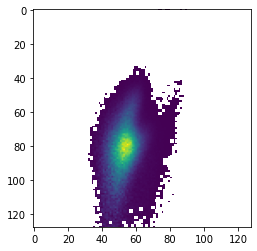

fcs/200511 CB/F6 1917


<Figure size 432x288 with 0 Axes>

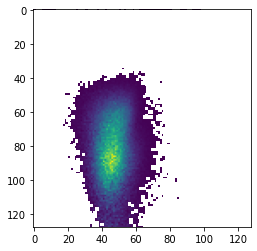

fcs/191014 CB/D2 961


<Figure size 432x288 with 0 Axes>

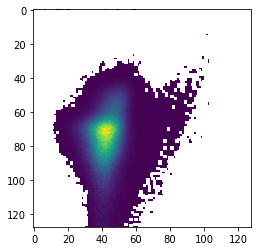

fcs/201019 CB/D7 2631


<Figure size 432x288 with 0 Axes>

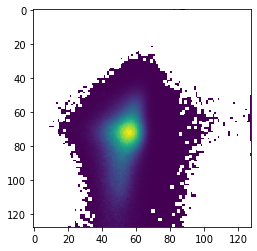

fcs/210125 CB/A8 2961


<Figure size 432x288 with 0 Axes>

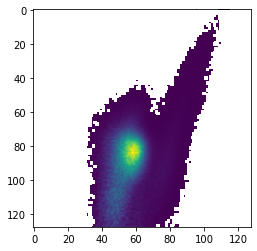

<Figure size 432x288 with 0 Axes>

In [84]:
AGQC.image_viewer(rand_select=5,mask_zero=True)

**Perform a PCA with the downsampled images of a selected gate.** 

In [85]:
n_components=5
PC_DF=AGQC.run_QC(population="CD34+CD45+", n_components=n_components)


Loaded data for CD34+CD45+ containing 3074 (128,128) images
PCs explained variance: 
[0.8911681  0.04075492 0.01855018 0.01732419 0.00966186]
Total visual variation explained: 0.9774592695757747


**In order to identify outliers easily, an interactive plot was created using JavaScript code.** In this plot, samples can be manually selected, and the selected samples will be saved in a dictionary called 'selected'. To perform QC, the contents of 'selected' will be stored in a list, and then the PCA will be repeated *without* those samples. The outliers of the new PCA will be manually selected, and the process will be repeated iteratively until there are no obvious outliers left. 

In [86]:
#Extra imports for interactive JavaScript-based plot
from random import random

from bokeh.layouts import row
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.plotting import figure, show, reset_output

In [100]:
#THIS IS THE WORKING ONE

output_notebook()

#Printing to terminal since bokeh takes up the notebook cell
terminal_output = open('/dev/stdout', 'w')
print('Running Bokeh on Notebook cell', file=terminal_output)


#PC labels
labels=['PC'+str(n) for n in np.arange(1,n_components+1,1)]

PC_DF_melt=pd.melt(PC_DF.reset_index(), id_vars='index', value_vars=labels, var_name='component')
s1=ColumnDataSource(PC_DF_melt) #source
s2=ColumnDataSource(PC_DF) #source2

#Common arguments for both plots
figkwds = dict(plot_width=500, plot_height=300, # webgl=True,
               x_axis_label='Component', y_axis_label='Value',
               tools="pan,lasso_select,box_select,reset,help")

#PC plot
p1 = figure(active_drag="lasso_select", x_range=labels, **figkwds)
p1.circle(source=s1, x="component", y="value",fill_alpha=0.2, size=5)

#PC1vPC2 Scatterplot
p2 = figure(active_drag="lasso_select", **figkwds)
p2.scatter(x='PC1', y='PC2', source=s2, alpha=0.8)
p2.xaxis.axis_label = 'PC1'
p2.yaxis.axis_label = 'PC2'

callback_obj = CustomJS(args=dict(s1=s1, s2=s2), code="""

        // Select the data       
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        
        var idx = []
        for (var i = 0; i < inds.length; i++) {
            idx.push(d1['index'][inds[i]])
        }
        
        // Generate a command to execute in Python              
        var data = {
            'idx': idx,
        }  
        var data_str = JSON.stringify(data)
        var cmd = "saved_selected("+data_str+")"

        // Execute the commands on the Python kernel
        var kernel = IPython.notebook.kernel;
        kernel.execute(cmd, {silent : false});
        
    """)
s1.selected.js_on_change('indices', callback_obj)
s2.selected.js_on_change('indices', callback_obj)


selected = dict()
def saved_selected(values):

    idx = np.array(values['idx'])
    data = {'idx': idx}
    print('Selected samples:', data, file=terminal_output)

    selected.update(data)
    return

layout= gridplot([[p1], [p2]])
handle = show(layout, notebook_handle=True)

Loading BokehJS ...

In [88]:
def print_selected():
    unique_IDs = list(set(selected['idx'].tolist()))
    for id in unique_IDs:
        print(id)
    return unique_IDs

In [101]:
if not samples_to_remove:
    samples_to_remove = print_selected()
else:
    samples_to_remove = samples_to_remove + print_selected()
samples_to_remove = list(set(samples_to_remove))
print(len(samples_to_remove), " samples in total")

fcs/191202 CB/B5 1178
fcs/190311 CB/A2 207
fcs/190429 CB/D6 396
fcs/191118 CB/D1 1116
fcs/181029 CB 60min/A2 28
fcs/191209 CB/C8 1226
fcs/190318 CB/A1 207
fcs/190318 CB/A2 208
fcs/190902 CB/B5 798
fcs/190211 CB/C2 231
fcs/190610 CB/C4 526
165  samples in total


### Iterative QC

In [102]:
oldPC_DF = PC_DF
PC_DF = AGQC.run_QC(population="CD34+CD45+", n_components=n_components, filter_samples=samples_to_remove)

Loaded data for CD34+CD45+ containing 3074 (128,128) images
PCs explained variance: 
[0.4338045  0.23896977 0.10515951 0.0501544  0.02926253]
Total visual variation explained: 0.8573507163673639
After filtering, 165 were removed (filter size: 165).


In [103]:
print(len(oldPC_DF.index))
print(len(PC_DF))

2920
2909


In [105]:
#WRITE samples_to_remove to file

with open('/home/antton/TFM/samples_to_remove_maj17.txt', 'w') as f:
    for item in samples_to_remove:
        f.write("%s\n" % item)

# Old Manual QC
Before the interactive PCA based sample selection was implemented, selection of faulty samples was done manually. The file names of the samples that should be discared were manually stored into a list.

In [17]:
incorrect_cd34_list = ['181029 CB 60min-A8 34',
'181203 CB-A3 77',
'181217 CB-B1 102'
'181217 CB-B2 103',
'181217 CB-C6 118',
'181217 CB-D5 125',
'181217 CB-E1 129',
'181217 CB-E6 136',
'190114 CB-B6 152',                       
'190128 CB-A5 152',
'190204 CB-A1 152',
'190204 CB-C6 220',
'190401 CB-E3 341',
'190408 CB-C5 369',
'190429 CB-E5 403',
'190513 CB-E3 434',
'190527 CB-D5 501',
'190624 CB-A5 529',                       
'190715 CB-A3 589',
'190715 CB-B1 628',
'190715 CB-B4 631',
'190715 CB-B6 633',
'190715 CB-B7 634',
'190715 CB-B8 635',
'190715 CB-C1 636',
'190715 CB-C2 637',
'190715 CB-C3 639',
'190715 CB-C5 641',                       
'190715 CB-D7 652',
'190805 CB-D3 703',
'190916 CB-B1 849',
'190916 CB-B5 853',
'190916 CB-B7 855',                       
'190916 CB-D4 869',
'190916 CB-D7 872',
'190923 CB-A4 853',
'190923 CB-D2 892',
'191007 CB-C5 928',
'191007 CB-D7 938',
'191014 CB-B4 946',                    
'191028 CB-C6 983',
'191028 CB-D3 990',
'191104 CB-A2 925',
'191104 CB-C7 1030',
'191104 CB-F2 1056',
'191111 CB-E4 1087',
'191118 CB-B4 1099',
'191202 CB-B1 1173',
'191209 CB-B4 1212',
'191216 CB-C2 1250',
'191216 CB-D3 1262',
'191216 CB-D6 1265',
'200113 CB-A5 1273',
'200113 CB-B1 1277',
'200113 CB-C1 1285',
'200113 CB-C6 1291',
'200113 CB-C8 1293',
'200113 CB-D2 1295',
'200113 CB-D3 1296', 
'200113 CB-E5 1310',
'200203 CB-C6 1396',
'200203 CB-C4 1393-re',
'200316 CB-A2 1250',
'200316 CB-D6 1618',
'200323 CB-C2 1646',
'200323 CB-C2 1646',
'200323 CB-D8 1660',  
'200330 CB-B6 1674',                     
'200403 CB-D1 1722',
'200420 CB-B5 1776',
'200427 CB-B6 1816',
'200504 CB-B1 1850',
'200511 CB-B6 1885',
'200511 CB-D7 1902',
'200511 CB-E1 1904']


In [ ]:
#WRITE incorrect_cd34_list to file

with open('/home/antton/TFM/samples_to_remove_mar24.txt', 'w') as f:
    for item in incorrect_cd34_list:
        f.write("%s\n" % item)


## Retrieve sample name list from file
Independently of how the samples were selected, the sample names were stored into a file. Here we load that file and use the sample names to produce PDFs containing all relevant images for each sample, so that they can be manually checked one last time before being definately discarded. 

Since Cord Blood 

In [18]:
#read incorrect sample list from file
with open('/home/antton/TFM/samples_to_remove_mar16.txt', 'r') as f:
    samples_to_remove = []
    for line in f:
        samples_to_remove.append('fcs/'+line.rstrip().replace('-','/'))

In [19]:
samples_to_remove

['fcs/181029 CB 60min/A8 34',
 'fcs/181203 CB/A3 77',
 'fcs/181217 CB/B2 103',
 'fcs/181217 CB/C6 118',
 'fcs/181217 CB/D5 125',
 'fcs/181217 CB/E1 129',
 'fcs/181217 CB/E6 136',
 'fcs/190114 CB/B6 152',
 'fcs/190128 CB/A5 152',
 'fcs/190204 CB/A1 152',
 'fcs/190204 CB/C6 220',
 'fcs/190401 CB/E3 341',
 'fcs/190408 CB/C5 369',
 'fcs/190429 CB/E5 403',
 'fcs/190513 CB/E3 434',
 'fcs/190527 CB/D5 501',
 'fcs/190624 CB/A5 529',
 'fcs/190715 CB/A3 589',
 'fcs/190715 CB/B1 628',
 'fcs/190715 CB/B4 631',
 'fcs/190715 CB/B6 633',
 'fcs/190715 CB/B7 634',
 'fcs/190715 CB/B8 635',
 'fcs/190715 CB/C1 636',
 'fcs/190715 CB/C2 637',
 'fcs/190715 CB/C3 639',
 'fcs/190715 CB/C5 641',
 'fcs/190715 CB/D7 652',
 'fcs/190805 CB/D3 703',
 'fcs/190916 CB/B1 849',
 'fcs/190916 CB/B5 853',
 'fcs/190916 CB/B7 855',
 'fcs/190916 CB/D4 869',
 'fcs/190916 CB/D7 872',
 'fcs/190923 CB/A4 853',
 'fcs/190923 CB/D2 892',
 'fcs/191007 CB/C5 928',
 'fcs/191007 CB/D7 938',
 'fcs/191014 CB/B4 946',
 'fcs/191028 CB/C6 98

## Collect all faulty images to PDF

Create a PDF file that contains every available image for each sample in the list (one file per sample) in order to facilitate manual validation.

In [104]:
input_folder_path = '/home/antton/TFM/output/plots_maj7'
output_folder_path = '/home/antton/TFM/quality_control'
path_to_script = '/home/antton/TFM/utils/'
sample_numbers = []
for sample in samples_to_remove:
    sample_numbers.append(sample.split(' ')[-1])
    
for sample_number in list(set(sample_numbers)):
    !python utils/collectPDF_antton.py plots_maj7/ /home/antton/TFM/quality_control $sample_number

Sample selected:  190318 CB-A8 247
Sample selected:  190225 CB-B6 247
Sample selected:  200113 CB-D6 1301
Sample selected:  191202 CB-D7 1197
Sample selected:  191118 CB-G2 1144
Sample selected:  190527 CB-C3 491
Sample selected:  190527 CB-E4 508
Sample selected:  191216 CB-C2 1250
Sample selected:  200316 CB-A2 1250
Sample selected:  200113 CB-D5 1300
Sample selected:  191118 CB-D1 1116
Sample selected:  191104 CB-D4 1038
Sample selected:  191202 CB-C6 1188
Sample selected:  191118 CB-A8 1094
Sample selected:  190624 CB-B6 579
Sample selected:  191028 CB-B2 971
Sample selected:  190401 CB-E3 341
Sample selected:  191209 CB-C7 1225
Sample selected:  200113 CB-E4 1309
Sample selected:  200113 CB-B5 1281
Sample selected:  191202 CB-C4 1185
Sample selected:  191202 CB-C3 1184
Sample selected:  191118 CB-E6 1131
Sample selected:  191014 CB-D6 966
Sample selected:  200203 CB-A1 1101
Sample selected:  191118 CB-B6 1101
Sample selected:  191111 CB-B7 1065
Sample selected:  190916 CB-B7 855
S

In [74]:
len(list(set(sample_numbers)))

123